<a href="https://colab.research.google.com/github/DrSubbiah/1.Bayesian-Inference/blob/master/7_1_MCMC_BASICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color="darkyellow"> "There's an interesting distinction here between researchers and users of computational methods"
[Andrew Gelman](http://www.stat.columbia.edu/~gelman/)

**Research?**

[Meta](https://ai.facebook.com/results/?content_types%5B0%5D=publication)

[Google](https://research.google/pubs/)

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats  as st
import scipy
import pystan
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# <font color="darkblue"> Introduction

While developing a Bayesian model, it is imperative to deal with posterior distribution of a parameter given data. As long as it is tractable (to known distribution) most of the summaries could be obtained using associated closed form expressions. If former fails or the latter is not direct then we seek alternative approaches

<font color="red">*Disclaimer: This notes confines to a broad understanding of MCMC from a development point of view, utilities, need and relevance of techniques. Further readings on MC and MCMC are listed at the end of the material*

**<span style="color:darkblue">Conventional Symbols**

1. $\theta:$ Parameter

1. $p(X|\theta):$ Data Model

1. $p(\theta):$ Prior Model

1. $\pi(\theta|X):$ Posterior Model

## <font color="maroon"> Revisit: Closed form

## <<font color="darkgreen">Count variable Poisson-Gamma Model

$p(x|\theta) = \mathrm{Poisson}(\theta) \quad x=0,1,2,3,...$  $\theta>0$ is the parameter which denotes average number of event of interest and ranges in  $[0,~\infty)$.

Prior for $\theta$
$p(\theta) = \mathrm{Gamma(\alpha,\beta)} \quad \theta>0$ and parameters are shape:$\alpha>0$ and scale:$\beta>0$

<font color="blue"> Posterior
$\pi(\theta|X)=\mathrm{Gamma}(\sum{x_i+\alpha}, n+\frac{1}{\beta})$ $n+\frac{1}{\beta}$ is the rate parameter

## <font color="green">Advantage of closed form

- Ready-to-use Bayesian recipes. Few of Bayesian tool kit may exploit this flexibility

- Computational cost is low

- Interpretations are more direct

##<font color="red">Disadvantage of closed form

- Few summaries (percentiles) may not have closed-form expressions

- Prevents exploring alternate plausible prior models

- Mathematically intensive

- Computational cost is a concern (context dependent)

# <font color="maroon"> Monte Carlo Simulation

When a posterior is available in closed form, but summarizing few summaries may not be available in closed form, then simulations from it would help to obtain required summaries such as

- Posterior Mean $E(\theta|X)=\mathrm{mean}\Big(\hat\theta_i^{MC}\Big)$

- Posterior Variance $V(\theta|X)=\mathrm{variance}\Big(\hat\theta_i^{MC}\Big)$

- Median (any percentile)
$\mathrm{Med}(\theta|X)=\mathrm{median}\Big(\hat\theta_i^{MC}\Big)$

- Probabilities involving $\theta|X$

For a plausible value 'b' about $\theta$
$p(\theta|X<b)=\mathrm{proportion}\Big(\hat\theta_i^{MC}<b\Big)$ in 10000 draws

***Probability computations help to find required Bayesian credible intervals***


### MC approach depends completely on MC simulations; yet, closed form posterior is essential for implementing MC.

### Equally, there are MonteCarle algorithms to generate from an arbitrary function, like a posterior distribution in Bayesian world

##<font color="darkgreen"> Acceptane-Rejection Algorithm

Though this algorithm has some advantage the idea behind this is really interesting and applicable in other advanced simulation method

**Situation:** The desired function (Target distribution)  $f(x)$ is not easy to simulate

**Approach:** Propose a function (Instrumental / Candidate distribution) $g(x)$, to simulate from it directly

**Requirement** $\frac{f(x)}{g(x)}\le M$ for all $x$

**Algorithm** Two steps

  1. Generate $Y \sim g(x)$ $U \sim U[0,1]$

  1. Accept  $X = Y$ if $U \le \frac{f(Y)}{Mg(Y)}$ else reject Y

  Repeat


**Information**

The candidate densitycan be equal to one and hence instead $U$ is generated from $u[0,1]$ it can be generated from $U[0,M]$ and M can be selected as mode of $f(x)$

# Generation of Beta (a, b)

In [ ]:
def p(x,a,b):
    return st.beta.pdf(x,a,b,loc=0,scale=1)

In [ ]:
def accept_reject(N,a,b):
    xmin = -5
    xmax = 5
    pmax = (a-1)/(a+b-2) #Mode of Beta distribution

    n_accept=0
    x_list = []
    while n_accept < N:
        y = (xmax-xmin)*np.random.rand() + xmin
        u = np.random.rand()
        if u < p(y,a,b)/ pmax:
            n_accept += 1
            x_list.append(y)
    return x_list

In [ ]:
samp=accept_reject(N=10000,a=4,b=0.5)
np.mean(samp)

0.7945673751299082

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


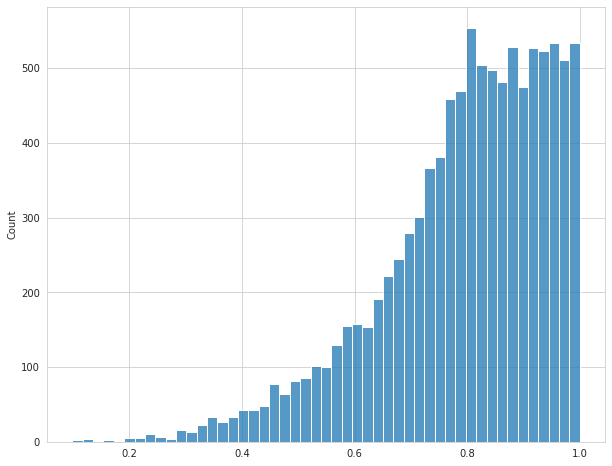

In [ ]:
fig = plt.figure(figsize = (10, 8))
sns.set_style('whitegrid')
ax=sns.histplot(np.array(samp))
plt.show()

# <font color="darkblue"> Markov Chain Monte Carlo

<font color="darkred"> Monte Carlo techniques may simulate iid samples from $f(x)$. Still we may explore Marvov Chain appraoch to get correlatd samples but have better convergence properties

## <font color="darkgreen">**Basics**

A Markov chain works on a simple principle of ***future depends only on the present not on the past***. More specifically, probability of occurrence of a uncertain event in a given instance depends completely on its immediate preceeding instance, not on its earlier instances (whether happened or not)

- Natural events like weather on a day may largely depend on its immediate preceding day; but may not depend on the whether five weeks ago

- A customer's chance of changing a brand of a cosmetic cream may be dependent on his/her immediate previous purchases

- A fresher's performance in his grad course may largely be influenced on his / her immediate schooling but not the performance in lower classes

All such cases are modeled by the following simple interesting Markov (discrete) chain

$$p(X_{n+1}=x_{n+1}|X_{n}=x_{n},X_{n-1}=x_{n-1}\cdots X_{0}=x_{0})=p(X_{n+1}=x_{n+1}|X_{n}=x_{n})$$

where $n+1, n, n-1\cdots 0$ indicate future, present and past respectively

This idea is largely exploited in Bayesian Data-Prior models; especially data models dependent on a parameter and posterior is conditioned on data. This twinning conditional relation helps to sample from one another and finally retain the sampling from the required distributions, precisely it should be posterior distribution

**So essential ingredients for MCMC are where to start, when to stop, how to allow them to mix and more importantly how to pick independent samples**

# <font color="darkblue"> MCMC - Overview

- Samples are drawn from a simple proposal distribution

- Each draw depends only on the previous draw

- Resultant Markov Chain will have a stationary distribution

- Only requirement is target distribution needs to be preoprtoinal to proposal

- One can use the correlated draws from the target distribution

- In Bayesian analysis, target = Posterior (upto normalizing constant)

# <font color = "darkblue"> Metropolis - Hastings (MH) Algorithm

In [ ]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 1
b = 10
lik = st.binom
prior = st.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + st.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)



In [ ]:
act_mean=(h+a)/(n+a+b)

MH_sim_mean=np.mean(samples)

print(act_mean,MH_sim_mean)

0.5585585585585585 0.5586026353983612


#<font color = "darkblue"> Gibbs Sampler

In [ ]:
n = 16
alpha = 2
beta = 4
niters = 50000
theta = np.zeros(niters+1)
x = np.zeros(niters+1)
theta[0] = 0.1
x[0]=1
for i in range(niters):
    x[i]=st.binom.rvs(n,theta[i-1],size=1)
    theta[i] = st.beta.rvs(a=alpha+x[i],b=n-x[i]+beta,loc=0,scale=1,size=1)

print(np.mean(x))
x

5.389152216955661


array([0., 1., 3., ..., 0., 3., 0.])

In [ ]:
act_BB=st.betabinom.rvs(n=n, a=alpha, b=beta, loc=0,size=10000)

In [ ]:
np.mean(act_BB)

5.287

# <font color="darkblue"> Slice Sampler </font>

This is exploiting the relationship between Uniform RV $U\sim\mathrm{Uniform}(0,1)$ and any distribution $X$ with PDF $f_X(x)$

That is, their Joint PDF is $\mathrm{Uniform}(0,f_X(x))$ yields Marginal PDFs

1. $f_{X|U}(x|u)$, sample x given u

1. $f_{U|X}(u|x)$, sample u given x

  - Starting with an arbitrary (plausible) point $x$, sample $u$ from $\mathrm{Uniform}(0,f_X(x)$)  

  - With this $u$, simulate $x$ from a Uniform distribution in the space $\mathcal{A} = \{x|f_X(x)\ge u$\}

## <font color="darkred"> Simulate from Normal$(\mu,\sigma^2)$ </font>

Minor Workout

1. PDF $f_X(x)=\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

1. if $u=f(x)$, then inverse is a solution of the QE on $x$ $$(x-\mu)^2=-2\sigma^2 \log(\sigma u \sqrt{2\pi})$$ provided the RHS is positive

1. This will bring $\mathcal{A} = \mathrm{Uniform}(\mu-x,\mu+x)$

In [ ]:
# Simulate from N(10, 32^2)
mu = 10
sigma = 32

def p(x):
    return st.norm.pdf(x, loc=mu, scale=sigma)

def p_inv(y):
    x = np.sqrt(-2*sigma**2 * np.log(y * sigma * np.sqrt(2*np.pi)))
    return mu-x, mu+x

iter=10000
samples = np.zeros(iter)
x = 0

for i in range(iter):
        u = np.random.uniform(0, p(x))
        x_lo, x_hi = p_inv(u)
        x = np.random.uniform(x_lo, x_hi)
        samples[i] = x

print(np.mean(samples),np.std(samples))

10.080964960858179 31.666782796729386


#<font color="darkblue"> HMC

Identify a proposal distribution $q(x)$

Perform a random walk - No aditional information about the target distribution $p(x)$

## Another opportunity

If the target distribution is differentiable, then we may have the access to its local behaviour

Derivatives helps to identify the rate of change (increasing / decreasing) near or at each point $x$ of $p(x)$

  that means changes in $p(x)$ when $x$ changes (through $q(x)$)

In this way it ay be possible to identify a state with high probabilities

## Intuitional and Physical Analogy

Random walk: A particle moving under the effect of a force attracting it to a higher-probabilty zones

Consider the negative log PDF $E[\mathrm{x}]=-\log p(\mathrm{x})$

This would help to identify the region with the largest probability of $p(x)$

Consequently, we have a proposal state to predict the way a point (particle) moves with a given position and velocity

In other words, $E[\mathrm{x}]$ will play the role of Potential Energy

The movement of the point has a momentum and has a kinetic energy

$$K=\frac{mv^2}{2}$$ with $m$ is set to one, this becomes $$K[v]=\frac{v^2}{2}$$

Hence, the total energy is

$$H[x,v]=K(v)+E(x)$$

## Core idea of HMC

Velocity $v$ is an auxillary variable

It samples the joint distribution of $x'$s position and momentum which is given by, $$\mathrm{exp}[-H(x,v)] = e^{-\frac{v^2}{2}}p(x)$$

Now we need to simulate from the joint distribution $p(x,v)$ similar to MH steps. Move and check the acceptance probability

Auxillary variable may be discarded from saving its value at each step

## Hamiltonian

The main idea is to describe how energy is converted (KE to PE and vice versa)

All we need to solve a set of DE and a set of initial conditions

Predict the loction and momentum of $x$ at any point in time [Eqns 2.1, 2.2_Neal 2011](https://arxiv.org/pdf/1206.1901.pdf)

These equations describe an object's ($x'$s) motion in time.

**Time is a continuous (measurable) variable, however, simulation in computers numerically, it is necessary to discretize the time**

[Analogy Rectanular Rule](http://www.mathcs.emory.edu/~cheung/Courses/170/Syllabus/07/rectangle-method.html)

  - Split the interval $T$ into a sequence of smaller intervals of length $h$

  - Smaller $h$, closer to the approximation

  - Done using **Leapfrog method**

  - Updates the position and momentum sequentially (half step to update the momentum, full step in time to update position)

  [Visual LF integrator](http://www.physics.drexel.edu/~steve/Courses/Comp_Phys/Integrators/leapfrog/)

  - Run for L steps

So, Hamiltonian dynamics is used as a proposal function for a Markov Chain to explore target distribution $p(x)$

  1. With the initial states, simulate Hamiltonian dynamics using leapfrog method

  1. Use the state of position and momentum variables till reaching L steps

    - Two input parameters L and $h$
    - Number of LF steps and length of jump
    - Smaller $h$ will give a better approximation
    - Larger L will displace $x$ further at each iteration
    - Working on these parameters adaptivley in NUTS
      - [JMLR 2014](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf)

  1. Proposed state is accepted using an update rule (similar to MH)



# <font color="darkgreen"> Recommended Reading List

1. [1949 Metropolis and Ulam](https://www.jstor.org/stable/2280232)

  - [Biopic](https://www.imdb.com/title/tt6875374/)

1. [1984 Geman 2](https://ieeexplore.ieee.org/document/4767596)  

1. [1992 Casella 2](http://www2.stat.duke.edu/~scs/Courses/Stat376/Papers/Basic/CasellaGeorge1992.pdf)

1. [1995 Chib](https://cs.brown.edu/courses/csci2951-n/resources/understanding-metropolis-alg.pdf)

1. [1995 Wilks+](https://www.taylorfrancis.com/books/mono/10.1201/b14835/markov-chain-monte-carlo-practice-gilks-richardson-david-spiegelhalter)

1. [1998 Kass+](https://www.stat.cmu.edu/~kass/papers/MCMCinPractice1998.pdf)

1. [2004 Robert PC](https://www.springer.com/gp/book/9780387212395)

1. [2005 Neal HMC](https://arxiv.org/pdf/1206.1901.pdf)

1. [2011 Neal](https://arxiv.org/pdf/1206.1901.pdf)

1. [2014  Hoffman](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf)

1. [2016 Goodman+](https://www.deeplearningbook.org/)

1. [2017 Betancourt](https://arxiv.org/pdf/1701.02434.pdf)

1. [2019 Review by Roy](https://arxiv.org/pdf/1909.11827.pdf)

1. **Optionally,** [Neal's 2000 to 2005](https://www.cs.toronto.edu/~radford/res-mcmc.html)

1. **Slow updates but worth reading:** [coding](https://github.com/ColCarroll/minimc)






# <font color="darkblue"> Users' Paradise

## <font color="darkred"> Handling MCMC

<font color="darkgreen"> ***Initial values:***

As we observed earlier, initial value of $X_{0}$ has to be specified for all the unknowns (parameters of interest). It dependes on the range of a parameter. For example, $0 < \theta <1$in a Beta-Binomial model has to be started with a number $(0,1)$. Any number in $(-\infty,+\infty)$ can be an initial point for the mean parameter in a Normal-Normal model. Here, a practical thinking is what will happen if we attempt different starting points for a parameter.

This opens up another ingredient namely, ***<font color="darkgreen">C: Number of Chains***; a Markov chain for each of the initial values

Then, ***<font color="darkgreen">N: Number of Simulations*** which is length of sequence of sampling;

<font color="darkgreen">Other items

***<font color="darkgreen">B:*** Number of burn-ins; initial warm-up samples may be dropped

***<font color="darkgreen">T:*** Thin; length of the interval to pick values during sampling;

**Then finally, generated sample will have**

***<font color="darkgreen">K:*** Number of samples = $\mathrm{C}\times\frac{N-B}{T}$

# <font color="darkblue"> Cautionary Tales

We illustrate with a simple Normal model for a not-so-good MCMC using diagnostic tools from STAN (trace and density plots)

$$X_1\sim N(\theta_1,\sigma_1^2)$$ and $$X_2\sim N(\theta_2,\sigma_2^2)$$ Define $\theta=\theta_1-\theta_2$. We are interested in modeling with Normal distribution for this difference parameter, $$\theta\sim N(\delta,\tau^2)$$ Other paramaters $\sigma_1^2$ and $\sigma_2^2$ can be modeled with suitable priors.$\delta,\tau^2$ are assigned with some suitable values

# <font color="maroon"> Different Attempts

We have attempted with different values for the essential inputs for a MCMC model.

1. <font color="darkgreen">C: Number of Chains

1. <font color="darkgreen">N: Number of Simulations

1.<font color="darkgreen">B: Number of burn-ins

1. <font color="darkgreen">T: Thin, period for saving samples





# <font color="darkblue"> Final word

<span style="color:blue">MCMC procedures for Prior-Data-Posterior modeling could be implemented in a suitable computing platform. However, monitoring MCMC run and understanding convergence diagnostics of MCMC sampling will be one of the important aspects to build better Bayesian models.

## Stan code

In [ ]:
stancode1 = """
data {
  int<lower=0> N;
  int<lower=0> M;
  real x[N];
  real y[M];
  real d;
  real<lower=0> tau;
  real a1;
  real<lower=0> b1;
  real a2;
  real<lower=0> b2;
}
parameters {
  real theta1;
  real theta2;
  real<lower=0> sigma1;
  real<lower=0> sigma2;

}
transformed parameters {
  real<lower=0> theta;
  theta = theta1-theta2;
  }
model {
  x ~ normal(theta1, sigma1);
  y ~ normal(theta2, sigma2);
  theta ~ normal(d,tau);
  sigma1 ~ cauchy(a1, b1)T[0,];
  sigma2 ~ cauchy(a2, b2)T[0,];

}
"""
posterior_1 = pystan.StanModel(model_code=stancode1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f3b339ee1e691f410b85e35ab245c834 NOW.


In [ ]:
x = [13,12,11,9,11,13,14,14,14,15]
y = [12,15,14,14,13,12,15,14,16,17]

data1={'x':x,
       'y':y,
       'N':len(x),
       'M':len(y),
       'd':0,
       'tau':100,
       'a1':0,
       'b1':100,
       'a2':0,
       'b2':100,}
data1

{'M': 10,
 'N': 10,
 'a1': 0,
 'a2': 0,
 'b1': 100,
 'b2': 100,
 'd': 0,
 'tau': 100,
 'x': [13, 12, 11, 9, 11, 13, 14, 14, 14, 15],
 'y': [12, 15, 14, 14, 13, 12, 15, 14, 16, 17]}

In [ ]:
fit1= posterior_1.sampling(data=data1)

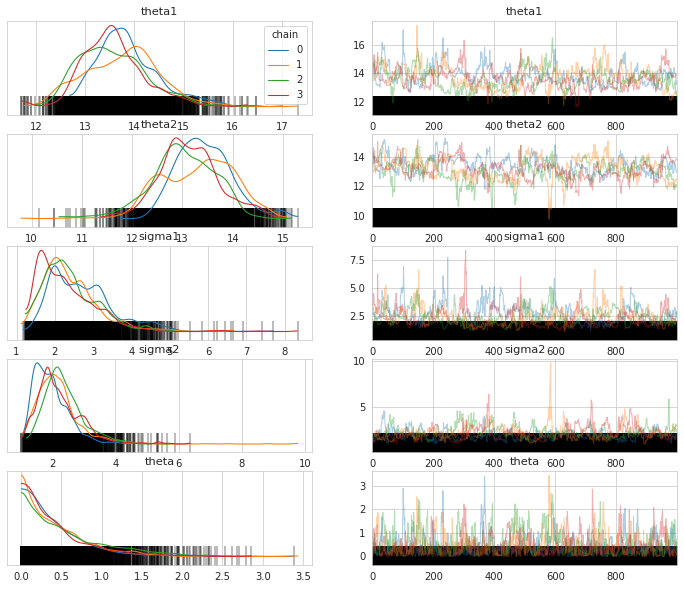

In [ ]:
az.plot_trace(fit1,compact=False, legend=True)
plt.show()

In [ ]:
fit1_summary=fit1.stansummary(probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4)
print(fit1_summary)

Inference for Stan model: anon_model_f3b339ee1e691f410b85e35ab245c834.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1 13.688  0.0768 0.6963 12.486 13.194 13.635 14.102 15.209     82 1.0464
theta2 13.217  0.0846 0.6737 11.889 12.780 13.226 13.673 14.540     63 1.0666
sigma1 2.4605  0.0794  0.795 1.4014 1.8907 2.2868 2.8944 4.4455    100 1.0525
sigma2 2.1873   0.062 0.6809 1.2597 1.7236  2.078 2.4966 3.8086    121 1.0383
theta  0.4702  0.0251 0.4569 0.0139 0.1348 0.3379 0.6564 1.6948    332 1.0091
lp__   -21.95  0.0902 1.5813 -25.87 -22.75 -21.69 -20.80 -19.76    308 1.0126

Samples were drawn using NUTS at Wed Jan  5 12:05:42 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
summ_mod=az.summary(fit1,round_to=3,hdi_prob=0.95)
summ_mod

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,13.688,0.696,12.404,15.070,0.082,0.058,68.048,213.766,1.047
theta2,13.218,0.674,12.011,14.610,0.096,0.069,47.312,206.064,1.069
sigma1,2.461,0.795,1.220,3.958,0.100,0.071,48.338,324.285,1.063
sigma2,2.187,0.681,1.119,3.462,0.060,0.042,101.388,380.261,1.048
theta,0.470,0.457,0.000,1.411,0.025,0.017,322.844,785.659,1.006


In [ ]:
fit2 = posterior_1.sampling(data=data1,
                 warmup = 2500,
                 thin=10,
                 iter = 10000,
                 chains=4,
                 control={"max_treedepth":15,"adapt_delta" : 0.999})

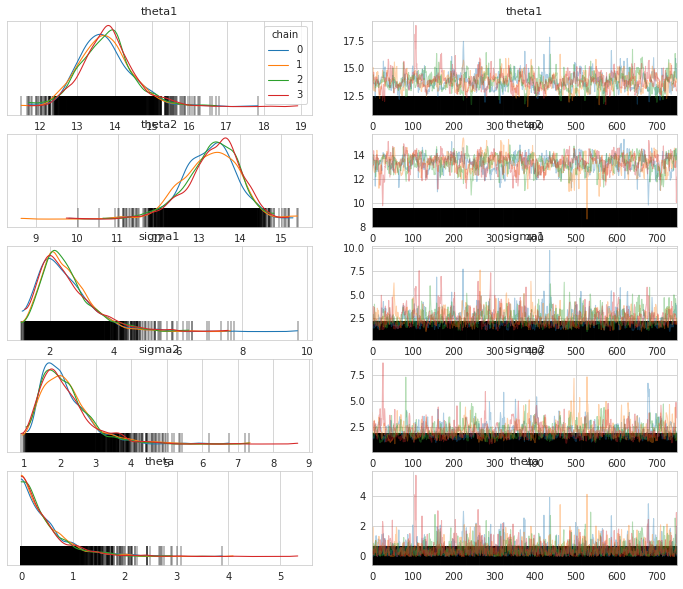

In [ ]:
az.plot_trace(fit2,compact=False, legend=True)
plt.show()

In [ ]:
summ_mod2=az.summary(fit2,round_to=3,hdi_prob=0.95)
summ_mod2

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,13.776,0.725,12.391,15.162,0.031,0.022,529.923,1074.709,1.004
theta2,13.295,0.673,11.996,14.540,0.028,0.020,559.324,1287.765,1.008
sigma1,2.514,0.837,1.248,4.099,0.030,0.021,702.323,1249.984,1.005
sigma2,2.147,0.733,1.072,3.578,0.028,0.020,605.954,1058.677,1.005
theta,0.481,0.490,0.000,1.452,0.013,0.009,1360.481,2071.199,1.002


In [ ]:
fit2_summary=fit2.stansummary(probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4)
print(fit2_summary)

Inference for Stan model: anon_model_f3b339ee1e691f410b85e35ab245c834.
4 chains, each with iter=10000; warmup=2500; thin=10; 
post-warmup draws per chain=750, total post-warmup draws=3000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1 13.776   0.031 0.7247 12.483 13.309 13.744 14.162 15.354    547 1.0035
theta2 13.295  0.0284  0.673 11.838 12.887 13.348 13.757 14.443    561 1.0088
sigma1 2.5145    0.03 0.8368 1.3737  1.931 2.3502 2.9135 4.5828    778 1.0028
sigma2 2.1469  0.0284 0.7333 1.2034  1.643 2.0047 2.4641 3.9174    669 1.0063
theta   0.481  0.0129 0.4903 0.0136 0.1387 0.3382 0.6489 1.7723   1452 1.0031
lp__   -21.99  0.0527 1.7255 -26.37 -22.80 -21.63 -20.73 -19.79   1073  1.006

Samples were drawn using NUTS at Wed Jan  5 12:11:52 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
fit3 = posterior_1.sampling(data=data1,
                 warmup = 25000,
                 thin=1,
                 iter = 50000,
                 chains=1,
                 control={"max_treedepth":15,"adapt_delta" : 0.999})

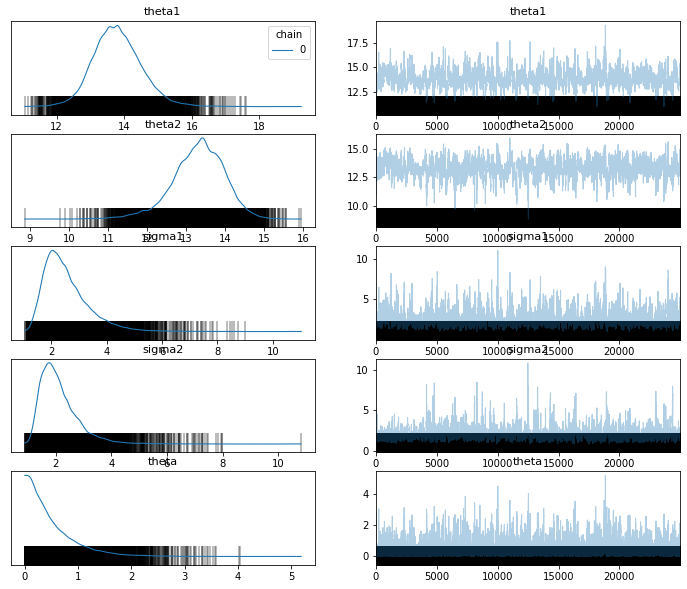

In [ ]:
az.plot_trace(fit3,compact=False, legend=True)
plt.show()

In [ ]:
fit3_summary=fit3.stansummary(probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4)
print(fit3_summary)

Inference for Stan model: anon_model_f3b339ee1e691f410b85e35ab245c834.
1 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=25000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1 13.799  0.0333 0.7215 12.486 13.318 13.764 14.237 15.311    470 1.0018
theta2 13.311  0.0307 0.6742 11.791 12.912 13.359 13.768 14.503    483 1.0013
sigma1 2.5221   0.031 0.8242 1.4252 1.9448 2.3492 2.9122 4.5471    705 1.0034
sigma2  2.123  0.0283 0.7236 1.2286 1.6393 1.9699 2.4299 3.8841    654 1.0002
theta  0.4885  0.0131 0.4718 0.0154 0.1503  0.347   0.68 1.7407   1299 1.0001
lp__   -22.00  0.0525 1.6998 -26.23 -22.85 -21.64 -20.76 -19.81   1049 1.0018

Samples were drawn using NUTS at Tue Jan  4 05:50:38 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
summ_mod3=az.summary(fit3,round_to=3,hdi_prob=0.95)
summ_mod3

Shape validation failed: input_shape: (1, 25000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,13.800,0.721,12.404,15.220,0.033,0.024,454.845,1027.607,NaN
theta2,13.311,0.674,11.857,14.538,0.030,0.022,478.956,1017.159,NaN
sigma1,2.522,0.824,1.254,4.144,0.031,0.022,605.036,1282.273,NaN
sigma2,2.123,0.724,1.093,3.499,0.028,0.020,643.460,1358.001,NaN
theta,0.489,0.472,0.000,1.427,0.013,0.009,1245.211,2723.737,NaN


# <font color="darkblue"> Observations

**Multiple Chains**

Chains have not properly mixed. Density plots also indicate failure of convergence

Looks better than Fit 1, when we compare Trace plots; however, low $N_{eff}$  indicates a not-so-good MCMC sample

**Single Long Chain**

It might be difficult to figure out from Trace plot, but together with low $N_{eff}$  indicate a not-so-good MCMC sample

We have mis-specified the underlying model . In STAN, we can carefully specify two more arguments for improving MCMC samples; please check [warnings](https://mc-stan.org/misc/warnings.html) and those constants have been considered in the present attempt. Nevertheless, the intention is to exemplify the issues in MCMC diagnostics.


## <font color="darkgreen"> Effective Sample Size

Given independent samples, the central limit theorem bounds uncertainty in estimates based on the number of samples $N$.

Given dependent samples, the number of independent samples is replaced with the effective sample size $N_{\mathrm{eff}}$, which is the number of independent samples with the same estimation power as the $N auto-correlated samples.

For example, estimation error is proportional to $1 / \sqrt{N_{\mathrm{eff}}}$ rather than $(1/\sqrt{N}$.

The effective sample size of a sequence is defined in terms of the **autocorrelations** within the sequence at different lags.

The autocorrelation $\rho_t$ at lag $t \geq 0$ for a chain with joint probability function $p(\theta)$ with mean $\mu$ and variance $\sigma^2 is defined to be

$\rho_t = \frac{1}{\sigma^2} \, \int_{\Theta} (\theta^{(n)} - \mu) (\theta^{(n+t)} - \mu) \, p(\theta) \, d\theta$

This is the correlation between the two chains offset by $t$ positions (i.e., a lag in time-series terminology). Because we know $\theta^{(n)}$ and $\theta^{(n+t)}$ have the same marginal distribution in an MCMC setting, multiplying the two difference terms and reducing yields

$ \rho_t = \frac{1}{\sigma^2} \, \int_{\Theta} \theta^{(n)} \, \theta^{(n+t)} \, p(\theta) \, d\theta$

The effective sample size of $N$ samples generated by a process with autocorrelations $\rho_t$ is defined by $ N_{\mathrm{eff}} \ = \ \frac{N}{\sum_{t = -\infty}^{\infty} \rho_t} \ = \ \frac{N}{1 + 2 \sum_{t = 1}^{\infty} \rho_t}$

In practice, the probability function in question cannot be tractably integrated and thus the autocorrelation cannot be calculated, nor the effective sample size.

Instead, these quantities must be estimated from the samples themselves. In practice,effective sample size estimator is based on autocorrelation of multiple chain  and split $(\hat{R})$ based.


The autocorrelation estimates $\hat{\rho}_{t,m}$ at lag $t$ from multiple chains $m \in (1,\ldots,M)$ are combined with within-sample variance estimate $(W)$ and multi-chain variance estimate $\widehat{\mbox{var}}^{+}$ are used to compute the combined autocorrelation at lag $t$ as

$\hat{\rho}_t = 1 - \frac{\displaystyle W - \textstyle \frac{1}{M}\sum_{m=1}^M \hat{\rho}_{t,m}} {\widehat{\mbox{var}}^{+}} $

If the chains have not converged, the variance estimator $\widehat{\mbox{var}}^{+}$ will overestimate variance, leading to an overestimate of autocorrelation and an underestimate effective sample size.


$ \hat{N}_{\mathrm{eff}} = \frac{M \cdot N}{\hat{\tau}}$

where

$ \hat{\tau} = 1 + 2 \sum_{t=1}^{2m+1} \hat{\rho}_t = -1 + 2 \sum_{t'=0}^{m} \hat{P}_{t'}$

where $\hat{P}_{t'}=\hat{\rho}_{2t'}+\hat{\rho}_{2t'+1}$. Initial positive sequence estimators is obtained by choosing the largest $m$ such that $\hat{P}_{t'}>0, \quad t' = 1,\ldots,m$

## <font color="darkblue"> Illustration - Auto correlation plots


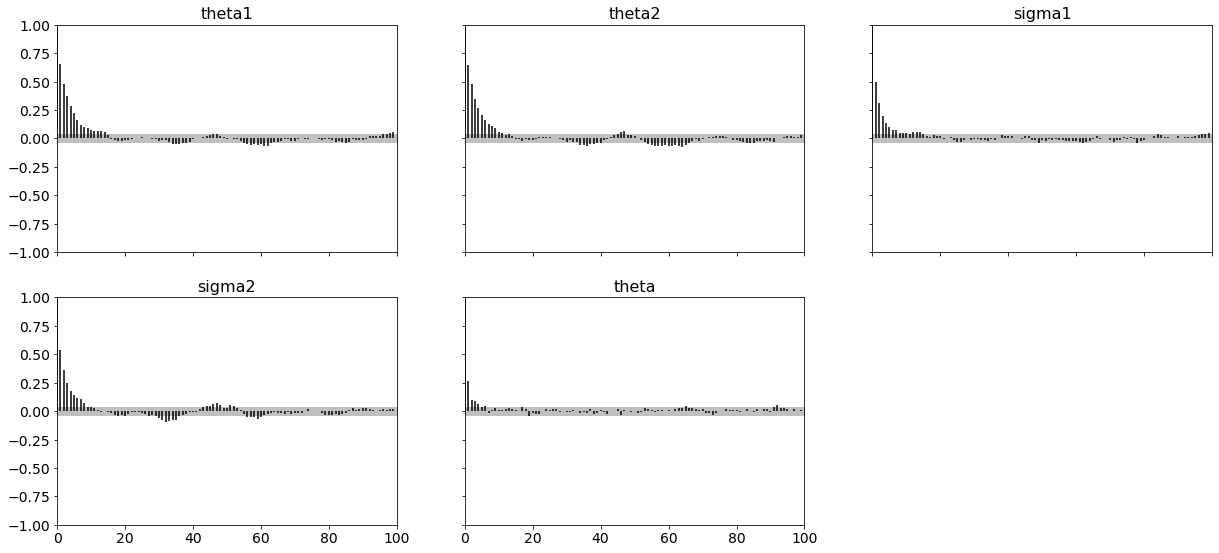

In [ ]:
acf_plt=az.plot_autocorr(fit2,combined=True)
acf_plt

plt.show()

# <font color="darkorange"> The long lasting Advice

[1998 Kass+](https://www.stat.cmu.edu/~kass/papers/MCMCinPractice1998.pdf)

## Page 5 Section 2.5 Poor Behavior of the Chain

# <font color="darkgreen"> Potential solution: fit a different model!

**Remarks**

- It may be difficult to prove that something has converged

- But may be sure to show something has not converged

- Equally, Convergence does not mean that one has a good model

- Few tricks to speed convergence are provided as recommendations (Standardizing variables, good initial values, checking sampling algorithms, long chains-may be 1,00,000 iterations)

- Other MCMC parameters and ESS parameters can be used sparingly but checking the convergence is a collective exercise

  - Tree depth, adaptive delta, ESS can be well understood from [Warning Source](https://mc-stan.org/misc/warnings.html) or [Stan Dev Guide](https://mc-stan.org/docs/2_27/reference-manual/hmc-algorithm-parameters.html)

  - MCSE can be referred from [Stan Ref manual](https://mc-stan.org/docs/2_27/reference-manual/effective-sample-size-section.html)

     - Gelman's words are noteworthy [MCSE](https://statmodeling.stat.columbia.edu/2007/04/02/markov_chain_mo/) as well as [P9 1998 Kass](https://www.stat.cmu.edu/~kass/papers/MCMCinPractice1998.pdf)

# <font color="darkblue"> Correcting the model

Major mis-specification  is the parameter $\theta$ is constrained which is not necessary, in fact it is unconstrained parameter

Hence, remove the constraint and use either

Option1: Position $\theta$ in generated quantities

or

Option2: Retain as a transformed variable

In [ ]:
stancode2 = """
data {
  int<lower=0> N;
  int<lower=0> M;
  real x[N];
  real y[M];
  real a1;
  real<lower=0> b1;
  real a2;
  real<lower=0> b2;
}
parameters {
  real theta1;
  real theta2;
  real<lower=0> sigma1;
  real<lower=0> sigma2;

}

model {
  x ~ normal(theta1, sigma1);
  y ~ normal(theta2, sigma2);
  sigma1 ~ cauchy(a1, b1)T[0,];
  sigma2 ~ cauchy(a2, b2)T[0,];

}
generated quantities {
  real theta;
  theta = theta1-theta2;
  }
"""
posterior_2 = pystan.StanModel(model_code=stancode2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_db980cb77398e8091f3e732ceac73aba NOW.


In [ ]:
fit2_1 = posterior_2.sampling(data=data1,
                 warmup = 2500,
                 thin=10,
                 iter = 20000,
                 chains=4,
                 control={"max_treedepth":15,"adapt_delta" : 0.999})

In [ ]:
az.plot_trace(fit2_1,compact=False, legend=True)
plt.show()

In [ ]:
summ_mod2_1=az.summary(fit2_1,round_to=3,hdi_prob=0.95)
summ_mod2_1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,12.575,0.715,11.149,13.987,0.009,0.006,6903.940,6071.877,1.0
theta2,14.209,0.615,12.985,15.420,0.007,0.005,7004.705,6540.167,1.0
sigma1,2.168,0.655,1.178,3.386,0.008,0.006,7088.466,6866.816,1.0
sigma2,1.908,0.558,1.053,2.988,0.007,0.005,6897.251,6721.586,1.0
theta,-1.634,0.938,-3.651,0.108,0.011,0.008,6743.902,6609.343,1.0


In [ ]:
fit2_1_summary=fit2_1.stansummary(probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4)
print(fit2_1_summary)

Inference for Stan model: anon_model_db980cb77398e8091f3e732ceac73aba.
4 chains, each with iter=20000; warmup=2500; thin=10; 
post-warmup draws per chain=1750, total post-warmup draws=7000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1 12.575  0.0087 0.7153 11.138 12.143 12.575 13.021 13.985   6794 0.9998
theta2 14.208  0.0074 0.6148 12.983 13.817 14.197 14.601 15.419   6825 1.0002
sigma1 2.1675  0.0078 0.6552  1.311 1.7234  2.041 2.4647 3.7548   6967 0.9999
sigma2 1.9082  0.0068 0.5584 1.1675 1.5274 1.8004 2.1622 3.2695   6772 0.9998
theta  -1.633  0.0115 0.9382 -3.565 -2.230 -1.631 -1.042 0.2083   6685 0.9999
lp__   -19.67  0.0195 1.5712 -23.63 -20.44 -19.31 -18.52 -17.70   6478 1.0001

Samples were drawn using NUTS at Tue Jan  4 15:24:49 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
stancode3 = """
data {
  int<lower=0> N;
  int<lower=0> M;
  real x[N];
  real y[M];
  real d;
  real<lower=0> tau;
  real a1;
  real<lower=0> b1;
  real a2;
  real<lower=0> b2;
}
parameters {
  real theta1;
  real theta2;
  real<lower=0> sigma1;
  real<lower=0> sigma2;

}
transformed parameters {
  real theta;
  theta = theta1-theta2;
  }
model {
  x ~ normal(theta1, sigma1);
  y ~ normal(theta2, sigma2);
  theta ~ normal(d,tau);
  sigma1 ~ cauchy(a1, b1)T[0,];
  sigma2 ~ cauchy(a2, b2)T[0,];

}
"""
posterior_3 = pystan.StanModel(model_code=stancode3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d776d5da15dcb022763a4d482836c3b2 NOW.


In [ ]:
fit3_1 = posterior_3.sampling(data=data1,
                 warmup = 2500,
                 thin=10,
                 iter = 20000,
                 chains=4,
                 control={"max_treedepth":15,"adapt_delta" : 0.999})

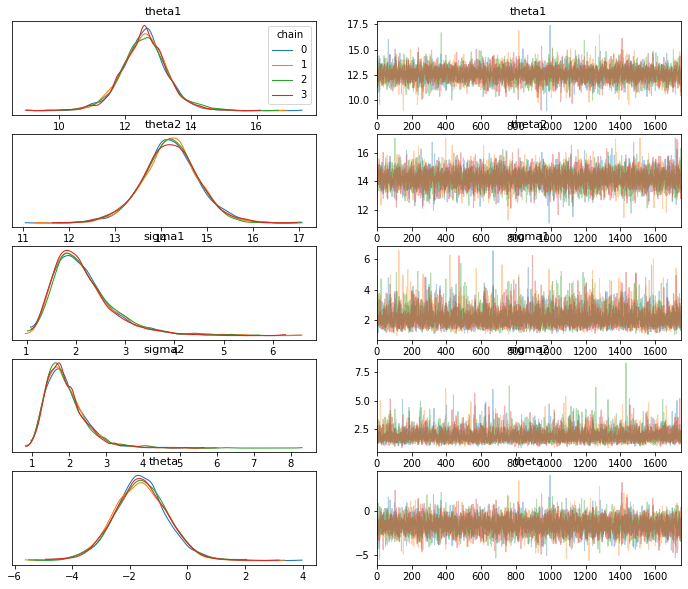

In [ ]:
az.plot_trace(fit3_1,compact=False, legend=True)
plt.show()

In [ ]:
summ_mod3_1=az.summary(fit3_1,round_to=3,hdi_prob=0.95)
summ_mod3_1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,12.590,0.714,11.222,14.091,0.008,0.006,7200.989,6242.147,1.0
theta2,14.206,0.626,12.959,15.460,0.007,0.005,7060.348,6951.307,1.0
sigma1,2.153,0.632,1.213,3.427,0.008,0.005,6982.693,6951.009,1.0
sigma2,1.907,0.566,1.062,2.974,0.007,0.005,6856.930,6748.327,1.0
theta,-1.616,0.947,-3.475,0.247,0.011,0.008,7152.120,6899.881,1.0


In [ ]:
fit2_1_summary=fit2_1.stansummary(probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=4)
print(fit2_1_summary)

Inference for Stan model: anon_model_db980cb77398e8091f3e732ceac73aba.
4 chains, each with iter=20000; warmup=2500; thin=10; 
post-warmup draws per chain=1750, total post-warmup draws=7000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1 12.575  0.0087 0.7153 11.138 12.143 12.575 13.021 13.985   6794 0.9998
theta2 14.208  0.0074 0.6148 12.983 13.817 14.197 14.601 15.419   6825 1.0002
sigma1 2.1675  0.0078 0.6552  1.311 1.7234  2.041 2.4647 3.7548   6967 0.9999
sigma2 1.9082  0.0068 0.5584 1.1675 1.5274 1.8004 2.1622 3.2695   6772 0.9998
theta  -1.633  0.0115 0.9382 -3.565 -2.230 -1.631 -1.042 0.2083   6685 0.9999
lp__   -19.67  0.0195 1.5712 -23.63 -20.44 -19.31 -18.52 -17.70   6478 1.0001

Samples were drawn using NUTS at Tue Jan  4 15:24:49 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
